In [25]:
# Partie 1 - Import des bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [26]:
# Partie 2 - Chargement des datasets
dataset_train = pd.read_csv('celery_Training_Set.csv')
dataset_test = pd.read_csv('celery_Test_Set.csv')

In [27]:
# Partie 3 - Nettoyage des noms de smells
def clean_smell_names(names):
    return [re.sub(r'[^A-Za-z0-9_]+', '_', name).strip('_') for name in names]

original_smell_names = list(dataset_train.columns[1:])
clean_names = clean_smell_names(original_smell_names)
num_smells = len(clean_names)
timestep = 2

In [28]:
# Partie 4 - Préparation des données
def prepare_data(df_train, df_test, col_index, timestep):
    train_vals = df_train.iloc[:, [col_index + 1]].values
    test_vals = df_test.iloc[:, [col_index + 1]].values
    full_vals = np.concatenate((train_vals, test_vals), axis=0)

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_vals)
    full_scaled = scaler.transform(full_vals)

    X_train, y_train = [], []
    for i in range(timestep, len(train_scaled)):
        X_train.append(train_scaled[i - timestep:i])
        y_train.append(train_scaled[i])
    X_train, y_train = np.array(X_train), np.array(y_train)

    X_test = []
    for i in range(len(train_vals), len(full_scaled)):
        X_test.append(full_scaled[i - timestep:i])
    X_test = np.array(X_test)

    return X_train, y_train, X_test, test_vals, scaler

data = {}
scalers = {}

for i, name in enumerate(clean_names):
    X_train, y_train, X_test, real_vals, scaler = prepare_data(dataset_train, dataset_test, i, timestep)
    data[name] = {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'real': real_vals}
    scalers[name] = scaler

In [29]:
# Partie 5 - Création du modèle multi-head
def build_multihead_model(timestep, names):
    inputs, outputs = [], []
    for name in names:
        inp = Input(shape=(timestep, 1), name=f'input_{name}')
        x = LSTM(64, return_sequences=True)(inp)
        x = Dropout(0.2)(x)
        x = LSTM(64)(x)
        x = Dropout(0.2)(x)
        out = Dense(1, name=f'output_{name}')(x)
        inputs.append(inp)
        outputs.append(out)
    return Model(inputs=inputs, outputs=outputs)

model = build_multihead_model(timestep, clean_names)

losses = {f'output_{name}': 'mse' for name in clean_names}
metrics = {f'output_{name}': ['mae'] for name in clean_names}
model.compile(optimizer='adam', loss=losses, metrics=metrics)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_Hub_like_dep… │ (None, 2, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Scattered_fu… │ (None, 2, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Cyclic_depen… │ (None, 2, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_God_objects   │ (None, 2, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Unstable_dep… │ (None, 2, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Improper_API… │ (None, 2, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Redundant_ab… │ (None, 2, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_High_cycloma… │ (None, 2, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Deep_inherit… │ (None, 2, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_High_coupling │ (None, 2, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Low_cohesion  │ (None, 2, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Excessive_fa… │ (None, 2, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Large_file_s… │ (None, 2, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Complex_cond… │ (None, 2, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_Orphan_modul… │ (None, 2, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_90 (LSTM)      │ (None, 2, 64)     │     16,896 │ input_Hub_like_d… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_92 (LSTM)      │ (None, 2, 64)     │     16,896 │ input_Scattered_… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 749,775 (2.86 MB)

 Trainable params: 749,775 (2.86 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Partie 6 - Entraînement du modèle
X_train_dict = {f'input_{name}': data[name]['X_train'] for name in clean_names}
y_train_dict = {f'output_{name}': data[name]['y_train'] for name in clean_names}

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, verbose=1, min_lr=1e-6)
]

history = model.fit(X_train_dict, y_train_dict, epochs=100, batch_size=8, validation_split=0.2, callbacks=callbacks, verbose=1)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 60s 450ms/step - loss: 1.2467 - output_Complex_conditional_structures_loss: 0.0536 - output_Complex_conditional_structures_mae: 0.1632 - output_Cyclic_dependencies_loss: 0.1196 - output_Cyclic_dependencies_mae: 0.1461 - output_Deep_inheritance_trees_loss: 0.0000e+00 - output_Deep_inheritance_trees_mae: 0.0000e+00 - output_Excessive_fan_in_fan_out_loss: 0.0861 - output_Excessive_fan_in_fan_out_mae: 0.2041 - output_God_objects_loss: 0.1323 - output_God_objects_mae: 0.2623 - output_High_coupling_loss: 0.0871 - output_High_coupling_mae: 0.2240 - output_High_cyclomatic_complexity_loss: 0.0572 - output_High_cyclomatic_complexity_mae: 0.1645 - output_Hub_like_dependencies_loss: 0.0000e+00 - output_Hub_like_dependencies_mae: 0.0000e+00 - output_Improper_API_usage_loss: 0.1898 - output_Improper_API_usage_mae: 0.3506 - output_Large_file_sizes_loss: 0.0715 - output_Large_file_sizes_mae: 0.1840 - output_Low_cohesion_loss: 0.0551 - output_Low_cohesion_mae: 0.1

Hub-like dependencies:
  RMSE: 0.0000
  MAE: 0.0000


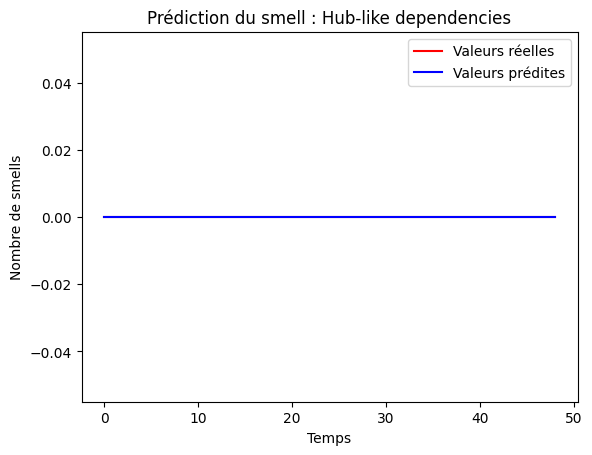

Scattered functionality:
  RMSE: 6.7029
  MAE: 5.4637


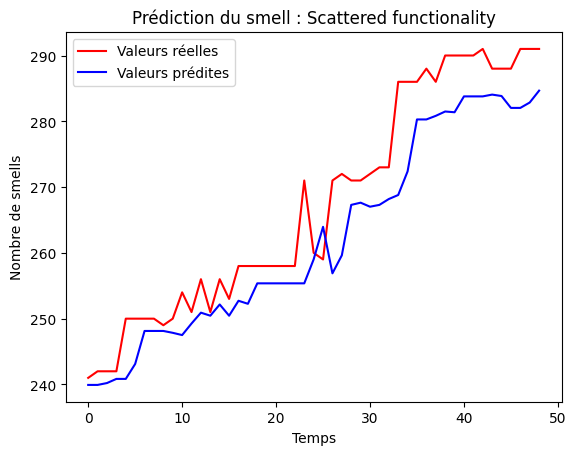

Cyclic dependencies:
  RMSE: 0.0095
  MAE: 0.0095


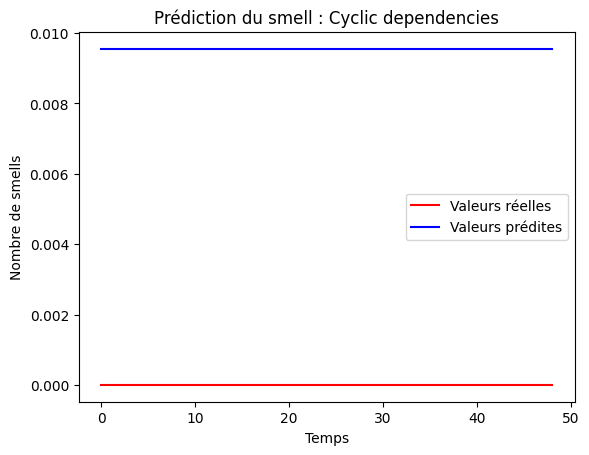

God objects:
  RMSE: 1.1177
  MAE: 0.8776


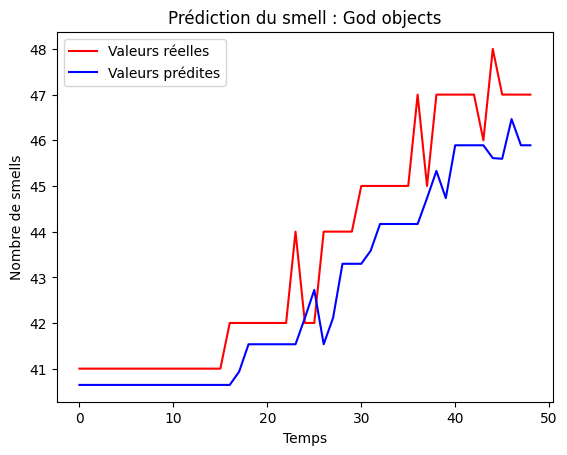

Unstable dependencies:
  RMSE: 3.2814
  MAE: 3.0856


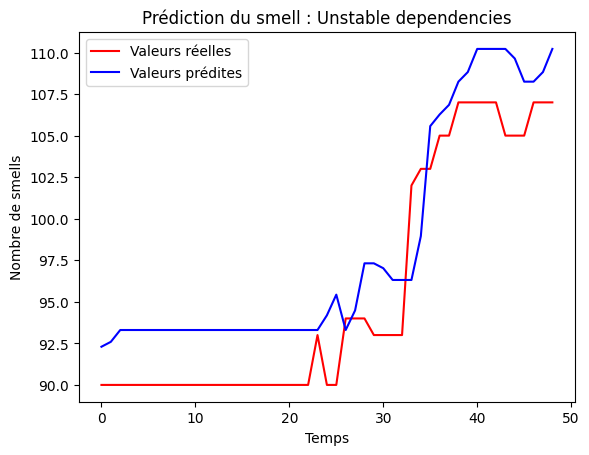

Improper API usage:
  RMSE: 3.2450
  MAE: 2.2438


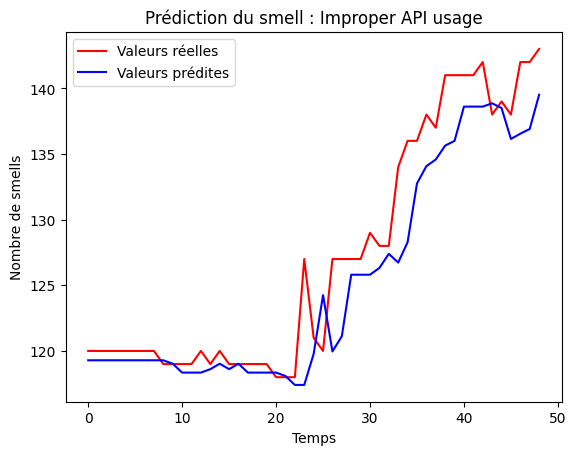

Redundant abstractions:
  RMSE: 0.2312
  MAE: 0.1372


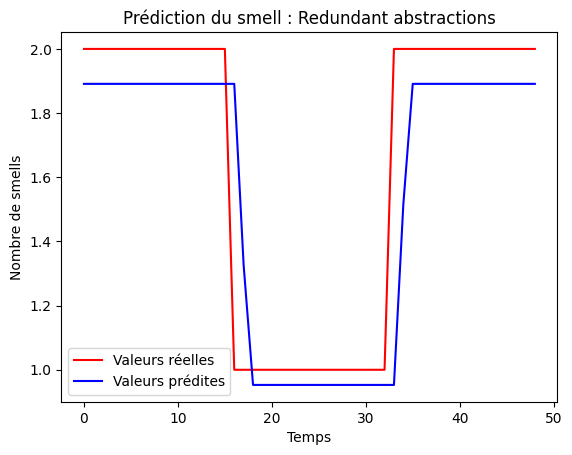

High cyclomatic complexity:
  RMSE: 1.6570
  MAE: 1.4741


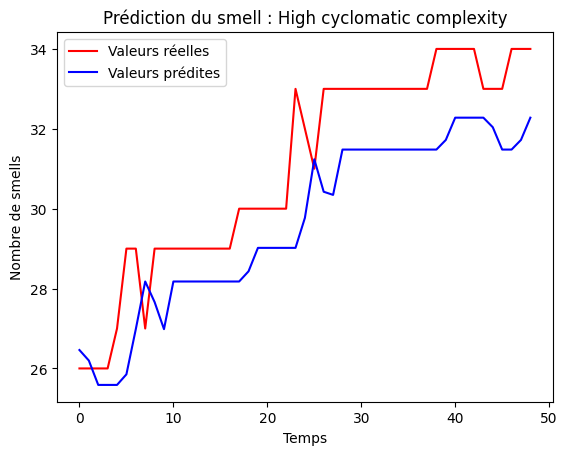

Deep inheritance trees:
  RMSE: 0.0000
  MAE: 0.0000


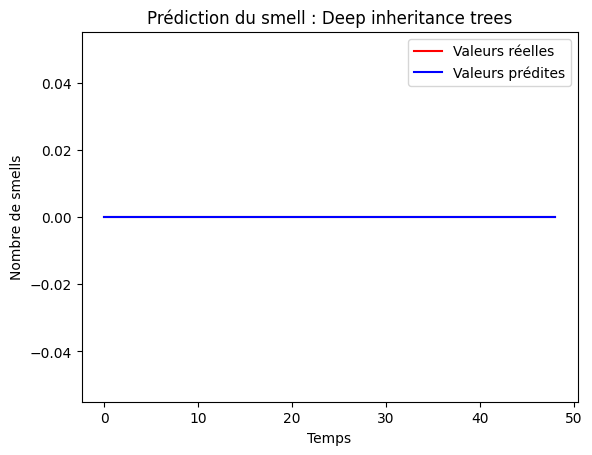

High coupling:
  RMSE: 4.8062
  MAE: 4.6099


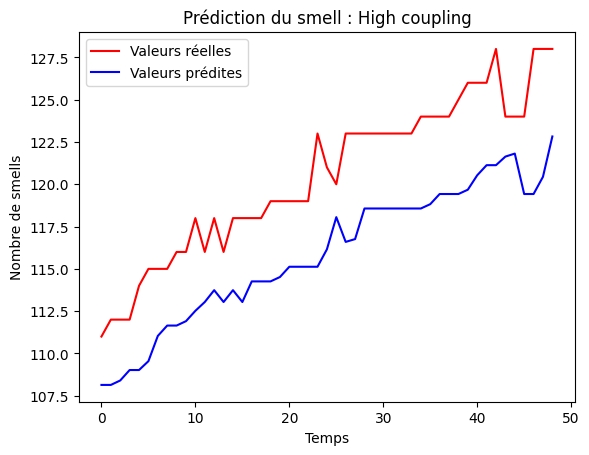

Low cohesion:
  RMSE: 4.1136
  MAE: 3.5950


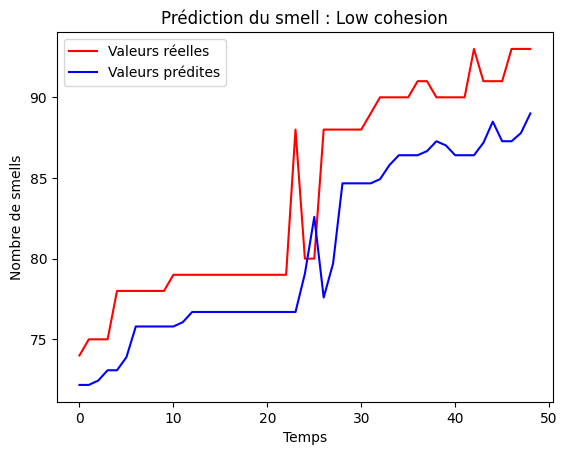

Excessive fan-in_fan-out:
  RMSE: 1.3723
  MAE: 0.9641


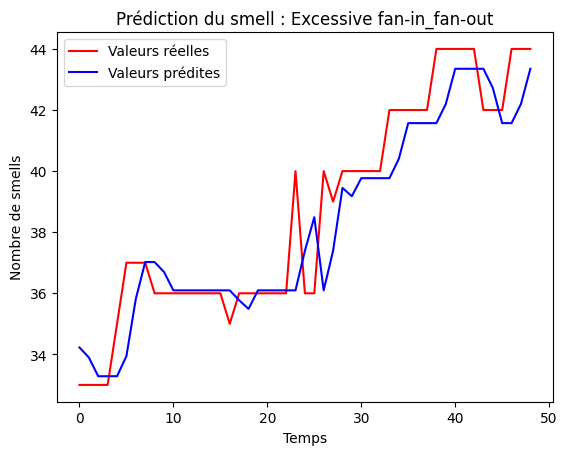

Large file sizes:
  RMSE: 2.2661
  MAE: 1.7925


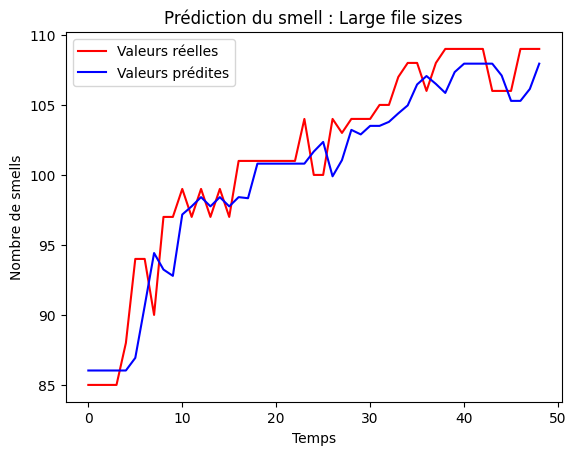

Complex conditional structures:
  RMSE: 5.4299
  MAE: 4.7026


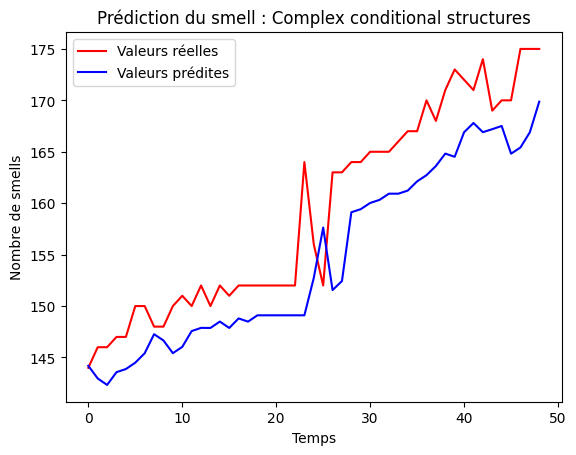

Orphan modules:
  RMSE: 0.4588
  MAE: 0.3235


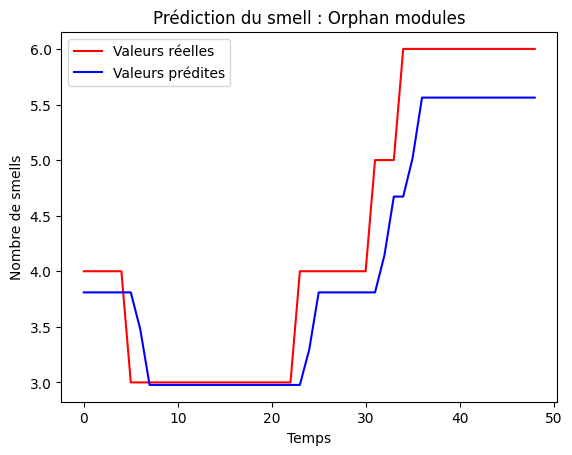

In [31]:
# Partie 7 - Prédictions et visualisation
rmse_scores = {}
mae_scores = {}

for name, original_name in zip(clean_names, original_smell_names):
    X_test = data[name]['X_test']
    true_values = data[name]['real']

    # Préparer les inputs pour toutes les têtes du modèle
    X_input_dict = {
        f'input_{other_name}': data[other_name]['X_test'] if other_name == name else np.zeros_like(data[other_name]['X_test'])
        for other_name in clean_names
    }

    # Prédire toutes les sorties
    preds_all = model.predict(X_input_dict, verbose=0)
    pred_scaled = preds_all[clean_names.index(name)]
    pred_denorm = scalers[name].inverse_transform(pred_scaled)

    # Calcul des métriques
    rmse = np.sqrt(mean_squared_error(true_values, pred_denorm))
    mae = mean_absolute_error(true_values, pred_denorm)
    rmse_scores[original_name] = rmse
    mae_scores[original_name] = mae

    # Affichage des scores
    print(f"{original_name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")

    # Affichage des courbes
    plt.figure()
    plt.plot(true_values, color='red', label='Valeurs réelles')
    plt.plot(pred_denorm, color='blue', label='Valeurs prédites')
    plt.title(f'Prédiction du smell : {original_name}')
    plt.xlabel('Temps')
    plt.ylabel('Nombre de smells')
    plt.legend()
    plt.show()